# Import and Load

In [57]:
import re
import pandas as pd
from nltk_setup import setup_nltk
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn
from textblob import TextBlob
import numpy as np
from collections import Counter


In [58]:
setup_nltk()

NLTK punkt is already downloaded
NLTK averaged_perceptron_tagger is already downloaded
NLTK stopwords is already downloaded


In [59]:
dg = pd.read_csv('icd11-25_data_clean_with_generated_descriptions.csv')
dg.columns

Index(['id', 'code', 'title', 'browser_url', 'class_kind', 'definition',
       'parent', 'inclusions', 'foundation_children',
       'foundation_child_references', 'index_terms', 'related_entities',
       'full_text', 'children', 'postcoordination_scales',
       'index_term_references', 'exclusions', 'exclusion_references',
       'fully_specified_name', 'generated_description', 'chapter'],
      dtype='object')

In [60]:
dg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13960 entries, 0 to 13959
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           13960 non-null  int64 
 1   code                         13062 non-null  object
 2   title                        13960 non-null  object
 3   browser_url                  13960 non-null  object
 4   class_kind                   13960 non-null  object
 5   definition                   6894 non-null   object
 6   parent                       13960 non-null  int64 
 7   inclusions                   1113 non-null   object
 8   foundation_children          1468 non-null   object
 9   foundation_child_references  1468 non-null   object
 10  index_terms                  10855 non-null  object
 11  related_entities             2287 non-null   object
 12  full_text                    13960 non-null  object
 13  children                     32

# Comparative Analysis

## Pre-processing

In [65]:
def preprocess_text(text, 
                   to_lowercase=True, 
                   remove_punctuation=True, 
                   lemmatize=True,
                   remove_stopwords=True):

    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    if to_lowercase:
        text = text.lower()
    
    # Remove punctuation
    if remove_punctuation:
        text = re.sub(r'[^\w\s]', ' ', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into text
    return ' '.join(tokens)

def create_preprocessed_columns(df, original_col='definition',
                                generated_col='generated_description',
                                to_lowercase=True,
                                remove_punctuation=True,
                                lemmatize=True,
                                remove_stopwords=True):

    # Create a copy of the dataframe
    df_processed = df[['id', 'chapter', original_col, generated_col]].copy()
    
    # Create new column names for preprocessed text
    original_processed = f"{original_col}_processed"
    generated_processed = f"{generated_col}_processed"
    
    # Apply preprocessing to both columns
    df_processed[original_processed] = df_processed[original_col].apply(
        lambda x: preprocess_text(x, 
                                to_lowercase=to_lowercase,
                                remove_punctuation=remove_punctuation,
                                lemmatize=lemmatize,
                                remove_stopwords=remove_stopwords)
    )
    
    df_processed[generated_processed] = df_processed[generated_col].apply(
        lambda x: preprocess_text(x,
                                to_lowercase=to_lowercase,
                                remove_punctuation=remove_punctuation,
                                lemmatize=lemmatize,
                                remove_stopwords=remove_stopwords)
    )
    
    return df_processed

## Information Density 

In [66]:
density_df = create_preprocessed_columns(
    dg,
    to_lowercase=True,
    remove_punctuation=True,
    lemmatize=False,
    remove_stopwords=False
)

### Length


Summary Statistics by Chapter Group:
--------------------------------------------------------------------------------

Chapters 1-6:
----------------------------------------

Character Length:
Original descriptions:
count    3136.000000
mean      300.444515
std       331.015981
min         0.000000
25%         0.000000
50%       224.000000
75%       447.000000
max      3654.000000
Name: definition, dtype: float64

Generated descriptions:
count    3136.000000
mean      862.842474
std       381.205759
min       120.000000
25%       640.750000
50%       754.000000
75%       935.250000
max      2638.000000
Name: generated_description, dtype: float64

Ratio (Generated/Original): 2.87

Chapters 7-12:
----------------------------------------

Character Length:
Original descriptions:
count    1986.000000
mean      179.010574
std       223.980229
min         0.000000
25%         0.000000
50%       119.500000
75%       273.750000
max      1507.000000
Name: definition, dtype: float64

Generated 

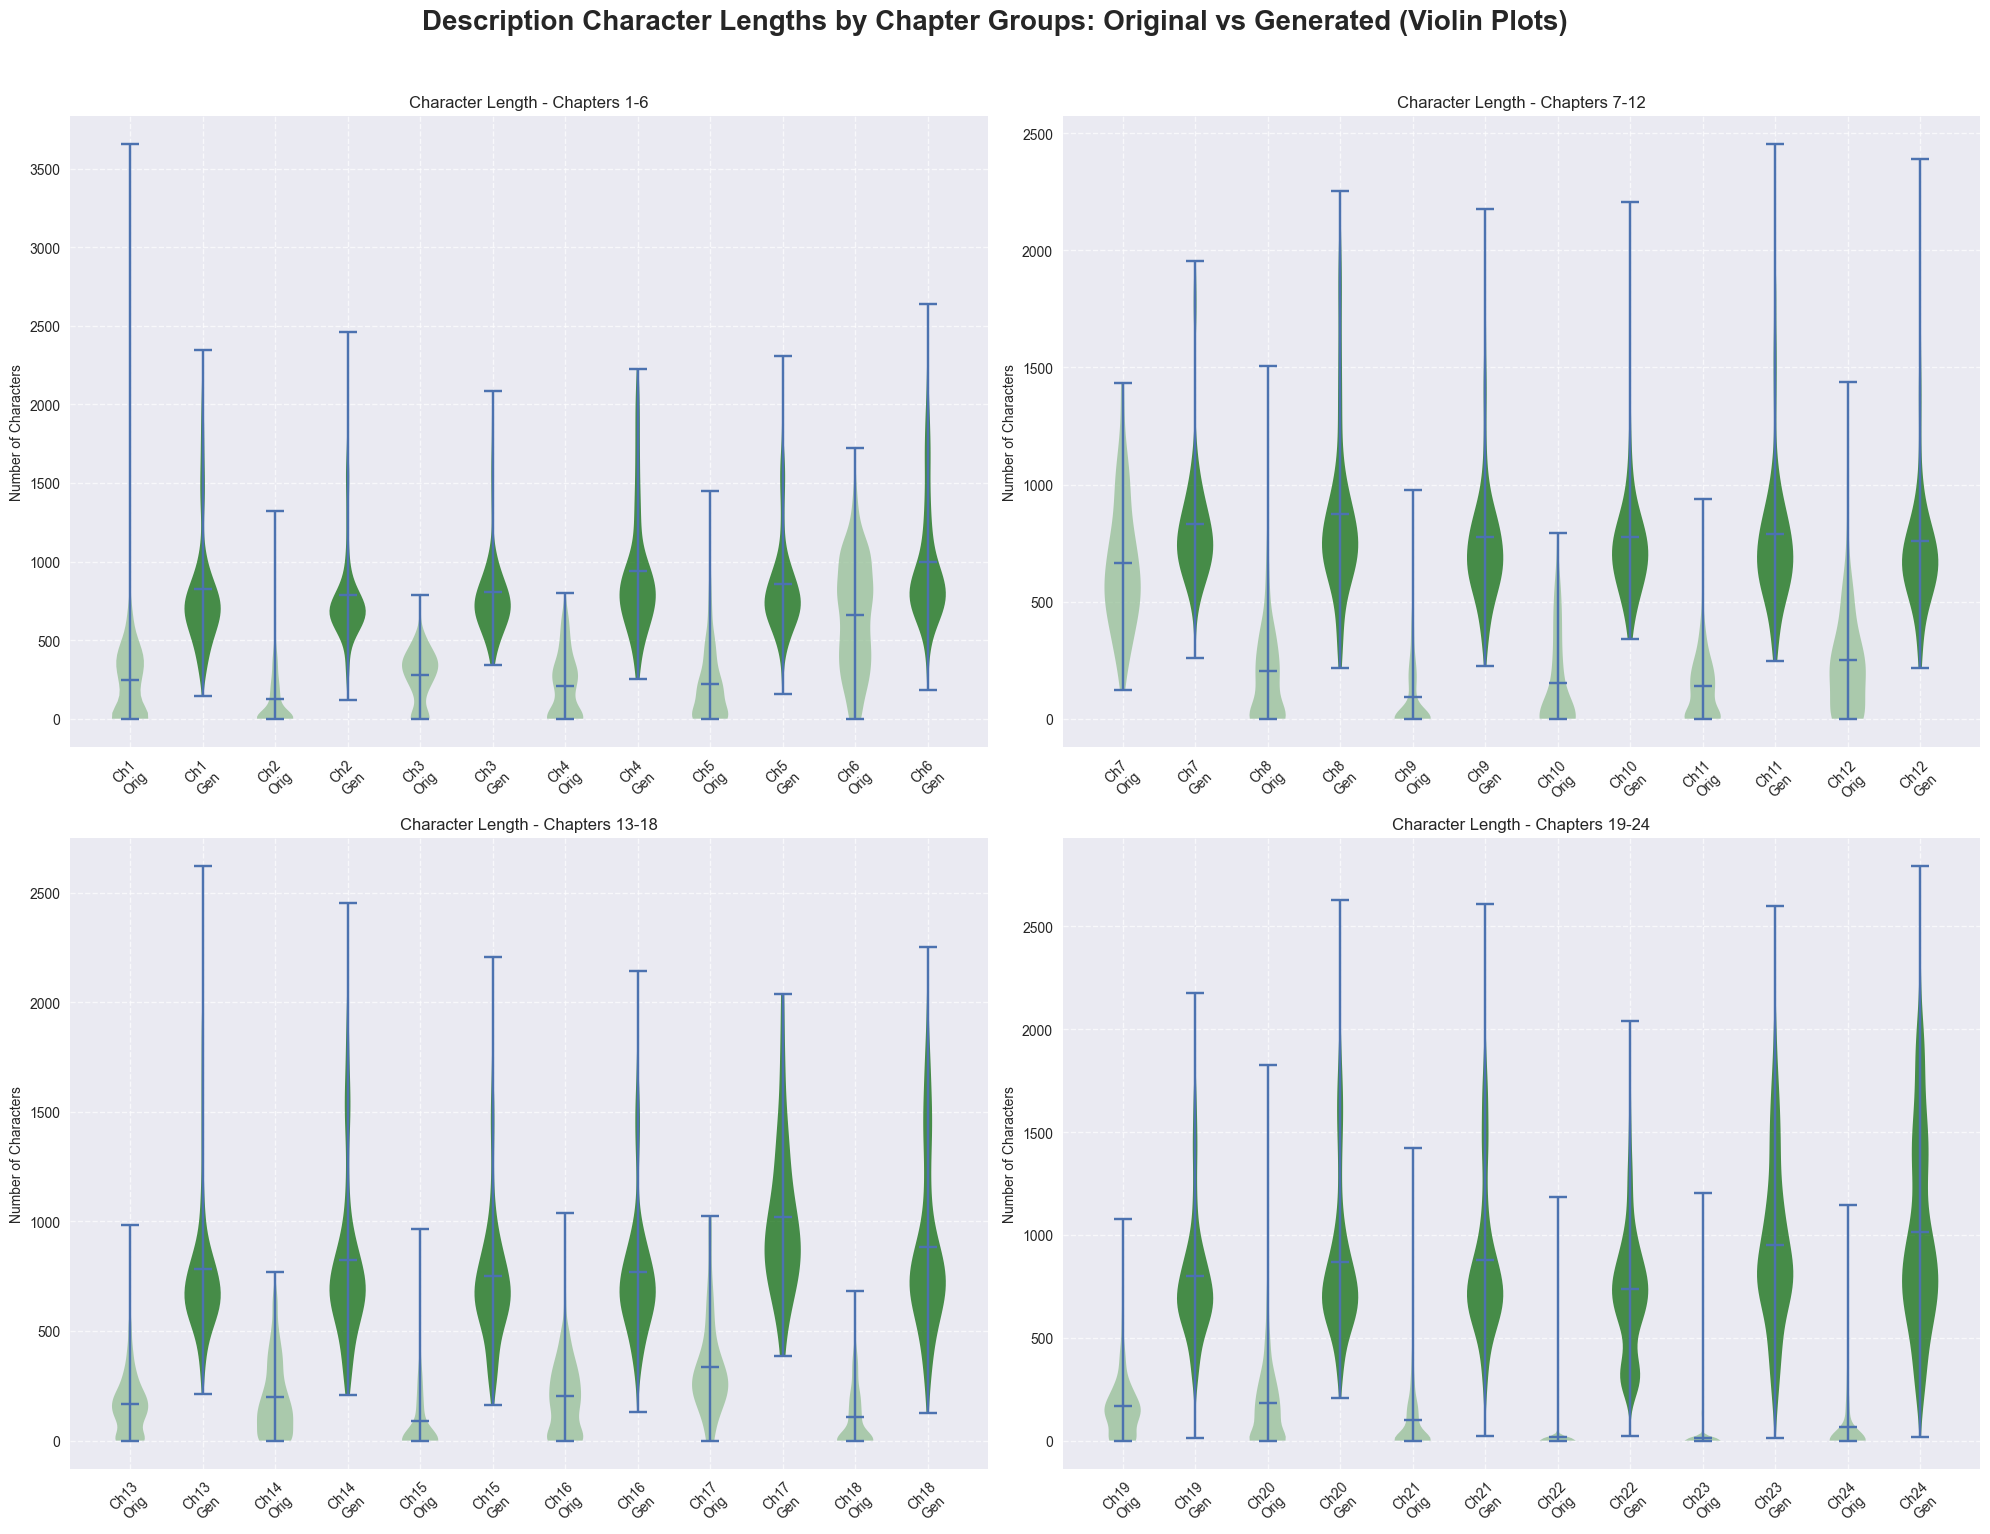

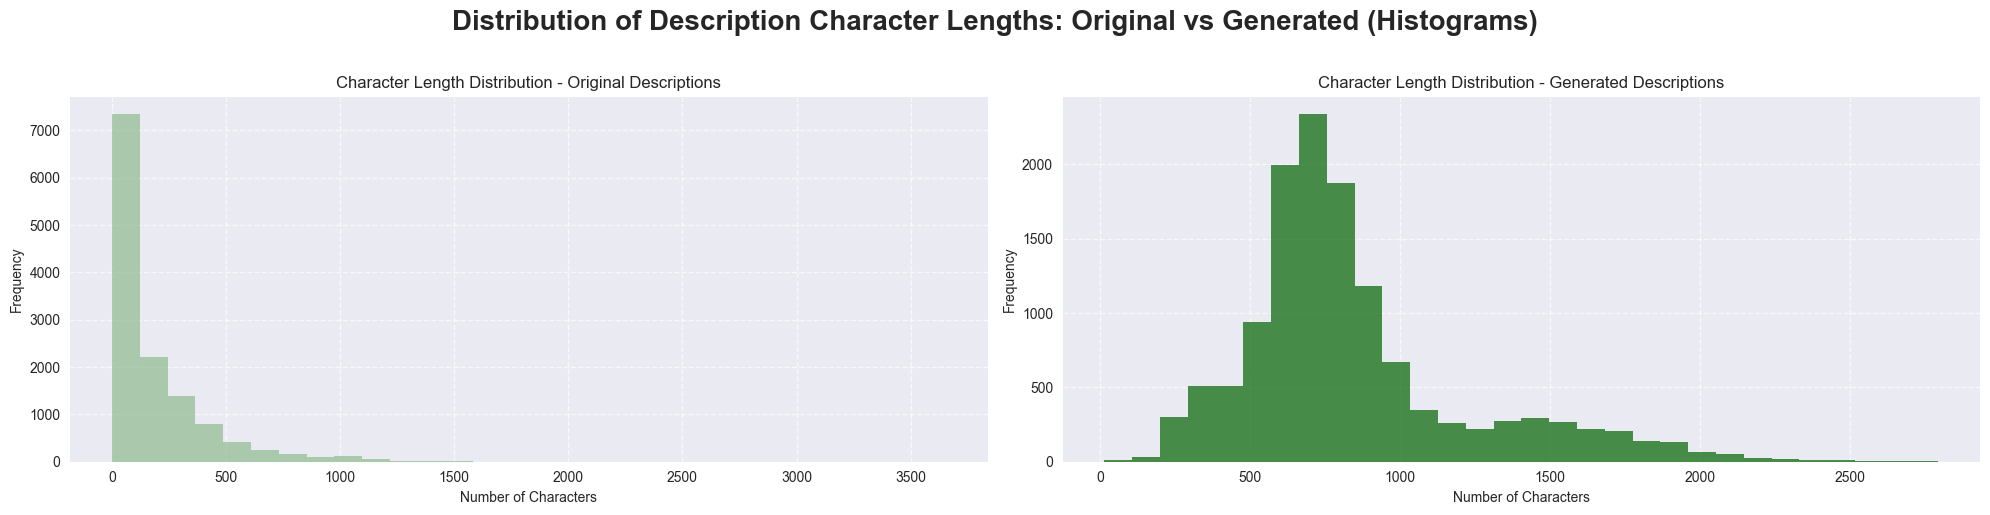

In [67]:
def analyze_description_lengths(df, 
                                original_col='definition',
                                generated_col='generated_description',
                                chapter_col='chapter'):
    """
    Analyze and compare lengths of original and generated descriptions across chapter groups.
    
    Args:
        df (pd.DataFrame): Input dataframe
        original_col (str): Column name for original descriptions
        generated_col (str): Column name for generated descriptions
        chapter_col (str): Column name for chapter information
    """
    # Set the style for all plots
    plt.style.use('seaborn-v0_8')
    colors = ['#8FBC8F', '#006400']  # Light green for original, dark green for generated
    
    # Create chapter groups
    chapter_groups = {
        '1-6': range(1,7),
        '7-12': range(7,13),
        '13-18': range(13,19),
        '19-24': range(19,25)
    }
    
    # Calculate character lengths
    length_func = lambda x: len(str(x))
    
    # Create a figure for violin plots
    fig_violin = plt.figure(figsize=(20, 15))
    plt.subplots_adjust(top=0.90)
    gs_violin = fig_violin.add_gridspec(2, 2)
    fig_violin.suptitle('Description Character Lengths by Chapter Groups: Original vs Generated (Violin Plots)', 
                     fontsize=20, fontweight='bold', y=1.02)
    
    # Create a separate figure for histograms
    fig_hist = plt.figure(figsize=(20, 5))
    plt.subplots_adjust(top=0.90)
    gs_hist = fig_hist.add_gridspec(1, 2)
    fig_hist.suptitle('Distribution of Description Character Lengths: Original vs Generated (Histograms)',
                    fontsize=20, fontweight='bold', y=1.02)
    
    # Prepare histogram data
    hist_orig_data = []
    hist_gen_data = []
    
    # Create violin plots for each chapter group
    for group_idx, (group_name, chapters) in enumerate(chapter_groups.items()):
        row = group_idx // 2
        col = group_idx % 2
        ax_violin = fig_violin.add_subplot(gs_violin[row, col])
        
        # Prepare data for violin plot
        violin_data = []
        labels = []
        
        # Calculate lengths for each chapter in group
        for chapter in chapters:
            chapter_data = df[df[chapter_col] == chapter]
            
            # Original descriptions
            orig_lengths = chapter_data[original_col].fillna('').apply(length_func)
            violin_data.append(orig_lengths)
            labels.append(f'Ch{chapter}\nOrig')
            hist_orig_data.extend(orig_lengths)
            
            # Generated descriptions
            gen_lengths = chapter_data[generated_col].apply(length_func)
            violin_data.append(gen_lengths)
            labels.append(f'Ch{chapter}\nGen')
            hist_gen_data.extend(gen_lengths)
        
        # Create violin plot
        violin = ax_violin.violinplot(violin_data,
                                    showmeans=True,
                                    showextrema=True)
        
        # Customize violin plot colors
        for i, pc in enumerate(violin['bodies']):
            pc.set_facecolor(colors[i % 2])
            pc.set_alpha(0.7)
        
        # Customize violin plot
        ax_violin.set_title(f'Character Length - Chapters {group_name}', fontsize=12)
        ax_violin.set_ylabel('Number of Characters', fontsize=10)
        ax_violin.set_xticks(range(1, len(labels) + 1))
        ax_violin.set_xticklabels(labels, rotation=45)
        ax_violin.grid(True, linestyle='--', alpha=0.7)
    
    # Create histograms (original and generated separately)
    ax_hist_orig = fig_hist.add_subplot(gs_hist[0, 0])
    ax_hist_gen = fig_hist.add_subplot(gs_hist[0, 1])
    
    # Original descriptions histogram
    ax_hist_orig.hist(hist_orig_data, bins=30, color=colors[0], alpha=0.7)
    ax_hist_orig.set_title('Character Length Distribution - Original Descriptions', fontsize=12)
    ax_hist_orig.set_xlabel('Number of Characters', fontsize=10)
    ax_hist_orig.set_ylabel('Frequency', fontsize=10)
    ax_hist_orig.grid(True, linestyle='--', alpha=0.7)
    
    # Generated descriptions histogram
    ax_hist_gen.hist(hist_gen_data, bins=30, color=colors[1], alpha=0.7)
    ax_hist_gen.set_title('Character Length Distribution - Generated Descriptions', fontsize=12)
    ax_hist_gen.set_xlabel('Number of Characters', fontsize=10)
    ax_hist_gen.set_ylabel('Frequency', fontsize=10)
    ax_hist_gen.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layouts
    fig_violin.tight_layout()
    fig_hist.tight_layout()
    
    # Print summary statistics
    print("\nSummary Statistics by Chapter Group:")
    print("-" * 80)
    
    for group_name, chapters in chapter_groups.items():
        print(f"\nChapters {group_name}:")
        print("-" * 40)
        
        group_data = df[df[chapter_col].isin(chapters)]
        
        print("\nCharacter Length:")
        print("Original descriptions:")
        print(group_data[original_col].fillna('').apply(length_func).describe())
        print("\nGenerated descriptions:")
        print(group_data[generated_col].apply(length_func).describe())
        
        # Calculate and print the ratio of generated to original
        orig_mean = group_data[original_col].fillna('').apply(length_func).mean()
        gen_mean = group_data[generated_col].apply(length_func).mean()
        if orig_mean > 0:  # Avoid division by zero
            ratio = gen_mean / orig_mean
            print(f"\nRatio (Generated/Original): {ratio:.2f}")

# Example usage:
analyze_description_lengths(density_df)

### Vocabolary Richness / Complexity

In [68]:
def calculate_vocabulary_richness(text):
    """
    Calculate Type-Token Ratio and Lexical Diversity for a text.
    
    Args:
        text (str): Input text
        
    Returns:
        tuple: (TTR, Lexical Diversity)
    """
    if not isinstance(text, str):
        return 0, 0
    
    # Tokenize and clean
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]  # Remove non-alphabetic tokens
    
    if not tokens:
        return 0, 0
    
    # Calculate metrics
    unique_words = len(set(tokens))
    total_words = len(tokens)
    
    # Type-Token Ratio
    ttr = unique_words / total_words if total_words > 0 else 0
    
    # Lexical Diversity (unique words per 1000 words)
    lexical_diversity = (unique_words / total_words) * 1000 if total_words > 0 else 0
    
    return ttr, lexical_diversity

def calculate_complexity(text):
    """
    Calculate Flesch-Kincaid Score and Medical Term Density.
    
    Args:
        text (str): Input text
        
    Returns:
        tuple: (Flesch-Kincaid Score, Medical Term Density)
    """
    if not isinstance(text, str):
        return 0, 0
    
    # Calculate Flesch-Kincaid Score
    blob = TextBlob(text)
    sentences = blob.sentences
    words = blob.words
    
    if not sentences or not words:
        return 0, 0
    
    # Flesch-Kincaid formula
    avg_sentence_length = len(words) / len(sentences)
    avg_syllables = sum(len(word) / 3 for word in words) / len(words)  # Approximate syllables
    flesch_kincaid = 0.39 * avg_sentence_length + 11.8 * avg_syllables - 15.59
    
    # Medical Term Density (approximation using word length > 8 as medical terms)
    medical_terms = sum(1 for word in words if len(word) > 8)
    medical_density = medical_terms / len(words) if words else 0
    
    return flesch_kincaid, medical_density

def analyze_chapter_metrics(df, 
                          original_col='definition',
                          generated_col='generated_description',
                          chapter_col='chapter'):
    """
    Analyze metrics across chapters.
    
    Args:
        df (pd.DataFrame): Input dataframe
        original_col (str): Column name for original descriptions
        generated_col (str): Column name for generated descriptions
        chapter_col (str): Column name for chapter information
    """
    # Set style
    plt.style.use('seaborn-v0_8')
    colors = ['#8FBC8F', '#006400']  # Dark green and lighter green
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    plt.subplots_adjust(top=0.85)  # Adjusted to make room for legend
    fig.suptitle('Vocabulary Richness and Complexity Analysis by Chapter', 
                 fontsize=20, fontweight='bold', y=0.98)
    
    # Initialize data storage
    chapter_metrics = {
        'TTR': {'original': [], 'generated': []},
        'Lexical_Diversity': {'original': [], 'generated': []},
        'Flesch_Kincaid': {'original': [], 'generated': []},
        'Medical_Density': {'original': [], 'generated': []}
    }
    
    # Calculate metrics for each chapter
    for chapter in sorted(df[chapter_col].unique()):
        chapter_data = df[df[chapter_col] == chapter]
        
        # Original descriptions
        orig_texts = chapter_data[original_col].fillna('')
        orig_ttr = [calculate_vocabulary_richness(text)[0] for text in orig_texts]
        orig_lex = [calculate_vocabulary_richness(text)[1] for text in orig_texts]
        orig_fk, orig_md = zip(*[calculate_complexity(text) for text in orig_texts])
        
        # Generated descriptions
        gen_texts = chapter_data[generated_col]
        gen_ttr = [calculate_vocabulary_richness(text)[0] for text in gen_texts]
        gen_lex = [calculate_vocabulary_richness(text)[1] for text in gen_texts]
        gen_fk, gen_md = zip(*[calculate_complexity(text) for text in gen_texts])
        
        # Store metrics
        chapter_metrics['TTR']['original'].append(np.mean(orig_ttr))
        chapter_metrics['TTR']['generated'].append(np.mean(gen_ttr))
        chapter_metrics['Lexical_Diversity']['original'].append(np.mean(orig_lex))
        chapter_metrics['Lexical_Diversity']['generated'].append(np.mean(gen_lex))
        chapter_metrics['Flesch_Kincaid']['original'].append(np.mean(orig_fk))
        chapter_metrics['Flesch_Kincaid']['generated'].append(np.mean(gen_fk))
        chapter_metrics['Medical_Density']['original'].append(np.mean(orig_md))
        chapter_metrics['Medical_Density']['generated'].append(np.mean(gen_md))
    
    # Create visualizations
    metrics = ['TTR', 'Lexical_Diversity', 'Flesch_Kincaid', 'Medical_Density']
    titles = ['Type-Token Ratio', 'Lexical Diversity', 'Flesch-Kincaid Score', 'Medical Term Density']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]
        
        x = np.arange(len(df[chapter_col].unique()))
        width = 0.35
        
        ax.bar(x - width/2, chapter_metrics[metric]['original'], 
               width, label='Original', color=colors[0], alpha=0.7)
        ax.bar(x + width/2, chapter_metrics[metric]['generated'], 
               width, label='Generated', color=colors[1], alpha=0.7)
        
        ax.set_title(title, fontsize=12, pad=10)
        ax.set_xlabel('Chapter', fontsize=10)
        ax.set_ylabel('Score', fontsize=10)
        ax.set_xticks(x)
        ax.set_xticklabels(sorted(df[chapter_col].unique()), rotation=45)
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add a single legend outside all subplots
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.94), ncol=2)
    
    plt.tight_layout()
    
    # Print summary statistics
    print("\nSummary Statistics by Metric:")
    print("-" * 80)
    
    for metric, title in zip(metrics, titles):
        print(f"\n{title}:")
        print("Original descriptions:")
        print(f"Mean: {np.mean(chapter_metrics[metric]['original']):.3f}")
        print(f"Std: {np.std(chapter_metrics[metric]['original']):.3f}")
        print("\nGenerated descriptions:")
        print(f"Mean: {np.mean(chapter_metrics[metric]['generated']):.3f}")
        print(f"Std: {np.std(chapter_metrics[metric]['generated']):.3f}")
        
        # Calculate and print the ratio
        ratio = np.mean(chapter_metrics[metric]['generated']) / np.mean(chapter_metrics[metric]['original'])
        print(f"\nRatio (Generated/Original): {ratio:.2f}")

def analyze_vocabulary_complexity(df, 
                                original_col='definition',
                                generated_col='generated_description',
                                chapter_col='chapter'):
    """
    Main pipeline for vocabulary richness and complexity analysis.
    
    Args:
        df (pd.DataFrame): Input dataframe
        original_col (str): Column name for original descriptions
        generated_col (str): Column name for generated descriptions
        chapter_col (str): Column name for chapter information
    """
    # Analyze chapter-wise metrics
    analyze_chapter_metrics(df, original_col, generated_col, chapter_col)


Summary Statistics by Metric:
--------------------------------------------------------------------------------

Type-Token Ratio:
Original descriptions:
Mean: 0.456
Std: 0.216

Generated descriptions:
Mean: 0.677
Std: 0.013

Ratio (Generated/Original): 1.48

Lexical Diversity:
Original descriptions:
Mean: 455.735
Std: 215.926

Generated descriptions:
Mean: 676.738
Std: 13.229

Ratio (Generated/Original): 1.48

Flesch-Kincaid Score:
Original descriptions:
Mean: 8.853
Std: 5.002

Generated descriptions:
Mean: 14.519
Std: 0.768

Ratio (Generated/Original): 1.64

Medical Term Density:
Original descriptions:
Mean: 0.128
Std: 0.068

Generated descriptions:
Mean: 0.209
Std: 0.021

Ratio (Generated/Original): 1.63


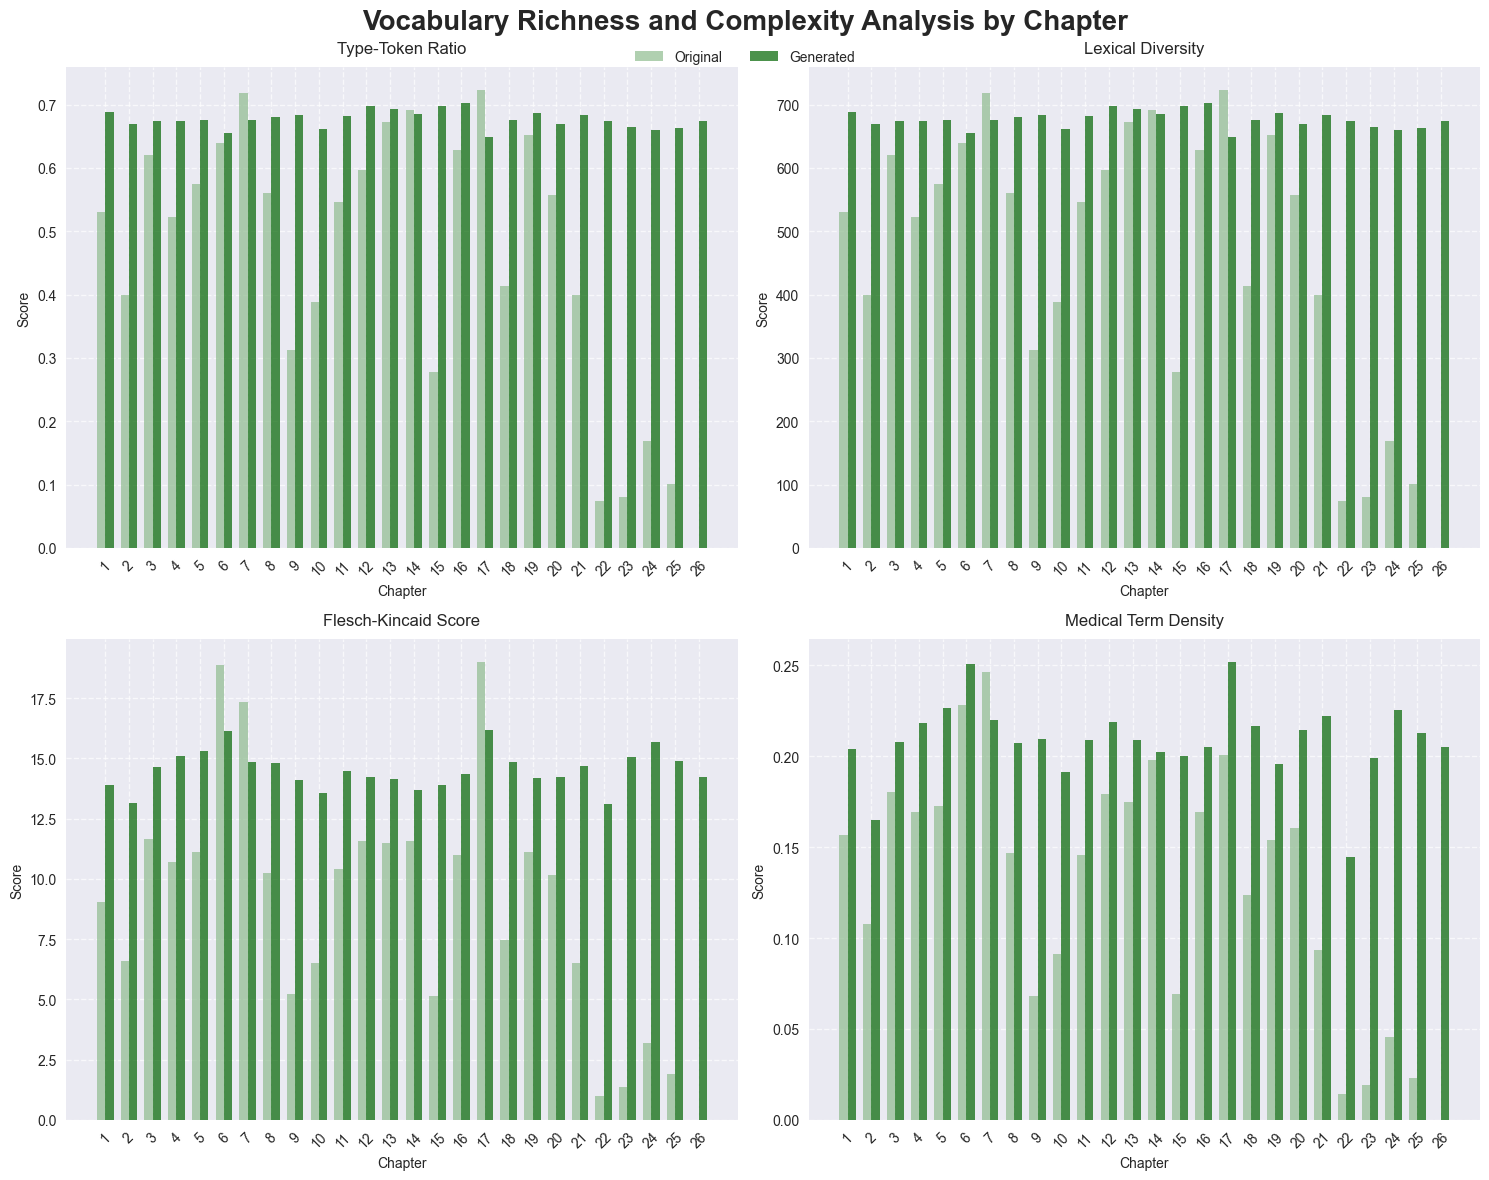

In [69]:
analyze_vocabulary_complexity(density_df)

### POS

In [70]:
def pos_analysis_pipeline(df, original_col='definition', generated_col='generated_description', chapter_col='chapter'):
    """
    Analyzes and visualizes POS distribution in original and generated descriptions.
    - Compares overall POS proportions between original and generated.
    - For generated, compares POS proportions across chapters.
    """

    nltk.download('punkt', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    
    # Define POS groups and colors
    pos_map = {
        'Noun': ['NN', 'NNS', 'NNP', 'NNPS'],
        'Verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
        'Adjective': ['JJ', 'JJR', 'JJS'],
        'Adverb': ['RB', 'RBR', 'RBS']
    }
    pos_colors = {
        'Noun': '#FFD700',      # Bright yellow
        'Verb': '#00BFFF',      # Bright blue
        'Adjective': '#FF69B4', # Bright pink
        'Adverb': '#32CD32',    # Bright green
    }
    pos_types = list(pos_map.keys())

    def get_pos_counts(text):
        if not isinstance(text, str) or not text.strip():
            return Counter()
        tokens = nltk.word_tokenize(text)
        tags = nltk.pos_tag(tokens)
        counts = Counter()
        for _, tag in tags:
            found = False
            for pos_name, tag_list in pos_map.items():
                if tag in tag_list:
                    counts[pos_name] += 1
                    found = True
                    break
        return counts

    # --- 1. Overall POS Proportion Comparison (Stacked Bar) ---
    orig_counts = Counter()
    gen_counts = Counter()
    orig_total = 0
    gen_total = 0

    for text in df[original_col].dropna():
        c = get_pos_counts(text)
        orig_counts += c
        orig_total += sum(c.values())
    for text in df[generated_col].dropna():
        c = get_pos_counts(text)
        gen_counts += c
        gen_total += sum(c.values())

    orig_props = [orig_counts.get(pos, 0) / orig_total if orig_total else 0 for pos in pos_types]
    gen_props = [gen_counts.get(pos, 0) / gen_total if gen_total else 0 for pos in pos_types]

    # Prepare data for stacked bar
    proportions = np.array([orig_props, gen_props])
    labels = ['Original', 'Generated']

    fig, ax = plt.subplots(figsize=(16, 12))
    bottom = np.zeros(len(labels))
    for i, pos in enumerate(pos_types):
        ax.bar(labels, proportions[:, i], bottom=bottom, color=pos_colors[pos], label=pos)
        bottom += proportions[:, i]
    ax.set_ylabel('Proportion', fontsize=12)
    ax.set_title('Overall POS Proportion: Original vs Generated', fontsize=20, pad=15, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    # Horizontal legend below the title
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=4, frameon=False)
    plt.subplots_adjust(top=0.85)  # Make more room for legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- 2. Generated Descriptions: POS by Chapter (Stacked Bar) ---
    chapters = sorted(df[chapter_col].unique())
    chapter_props = {pos: [] for pos in pos_types}
    for chapter in chapters:
        chapter_texts = df[df[chapter_col] == chapter][generated_col].dropna()
        chapter_counts = Counter()
        chapter_total = 0
        for text in chapter_texts:
            c = get_pos_counts(text)
            chapter_counts += c
            chapter_total += sum(c.values())
        for pos in pos_types:
            prop = chapter_counts.get(pos, 0) / chapter_total if chapter_total else 0
            chapter_props[pos].append(prop)

    # Prepare data for stacked bar
    proportions = np.array([chapter_props[pos] for pos in pos_types])
    fig, ax = plt.subplots(figsize=(16, 12))
    bottom = np.zeros(len(chapters))
    for i, pos in enumerate(pos_types):
        ax.bar(chapters, proportions[i], bottom=bottom, color=pos_colors[pos], label=pos)
        bottom += proportions[i]
    ax.set_ylabel('Proportion', fontsize=12)
    ax.set_xlabel('Chapter', fontsize=12)
    ax.set_title('POS Proportion in Generated Descriptions by Chapter', fontsize=20, pad=15, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=4, frameon=False)
    plt.subplots_adjust(top=0.85)  # Make more room for legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

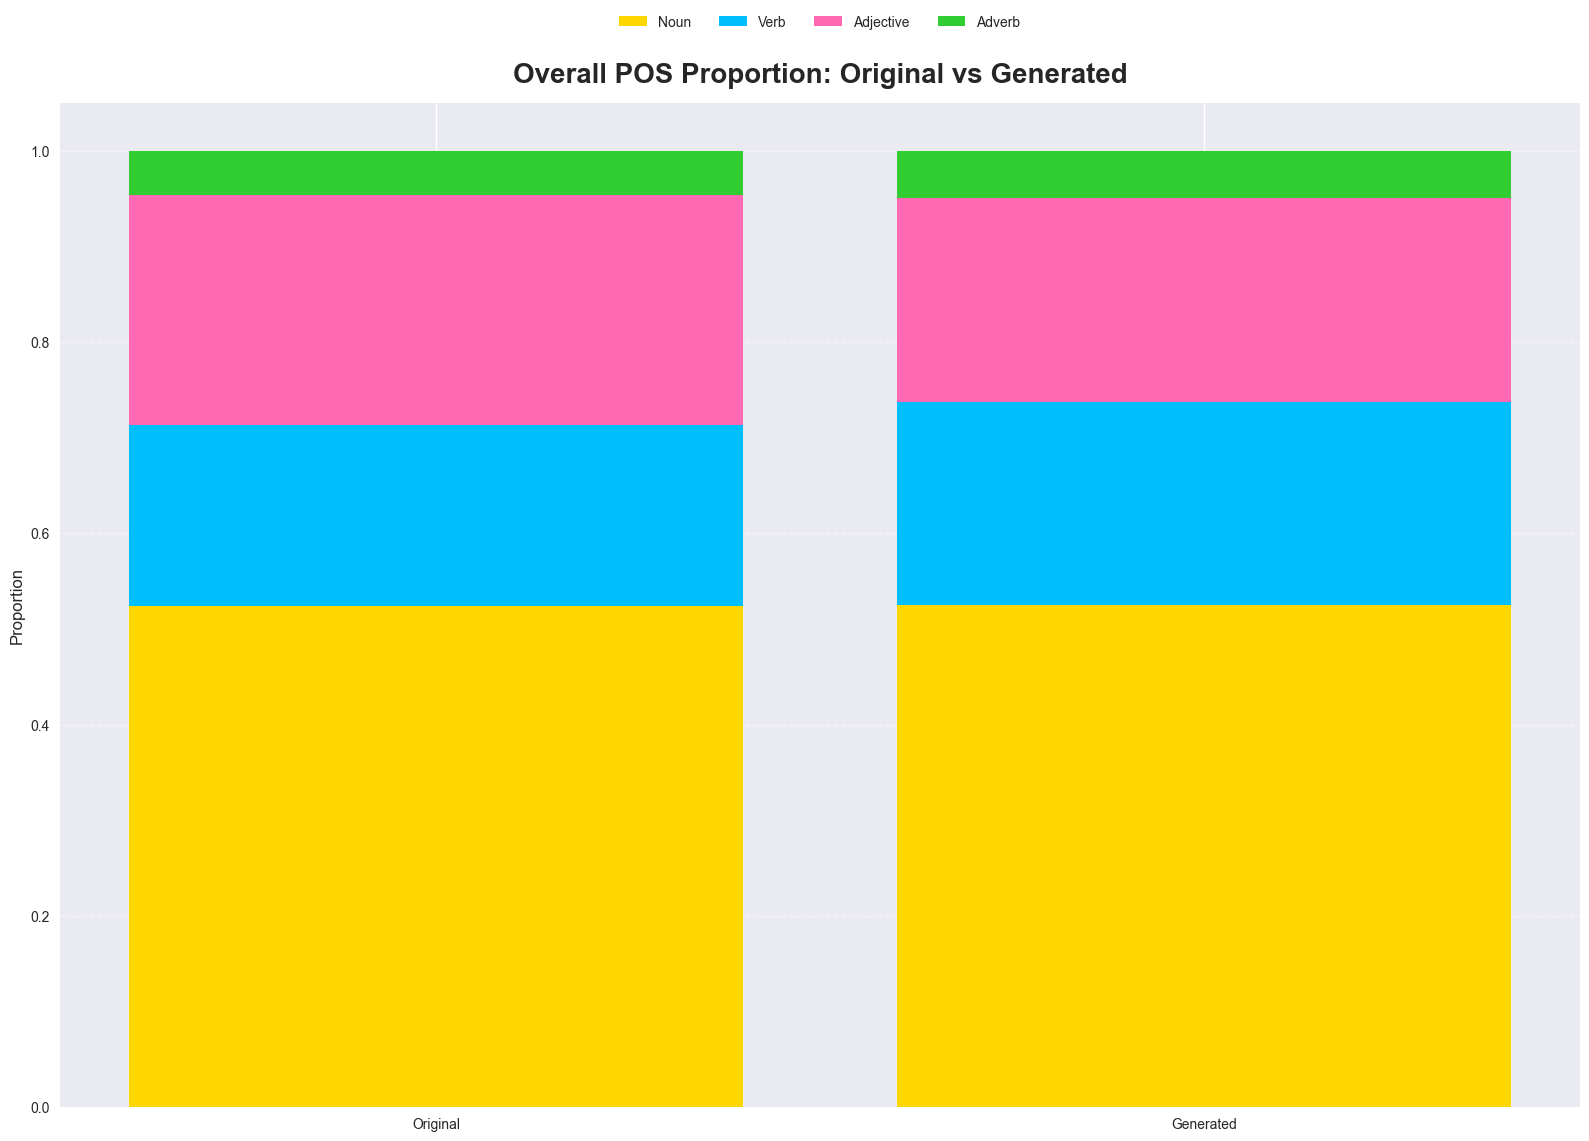

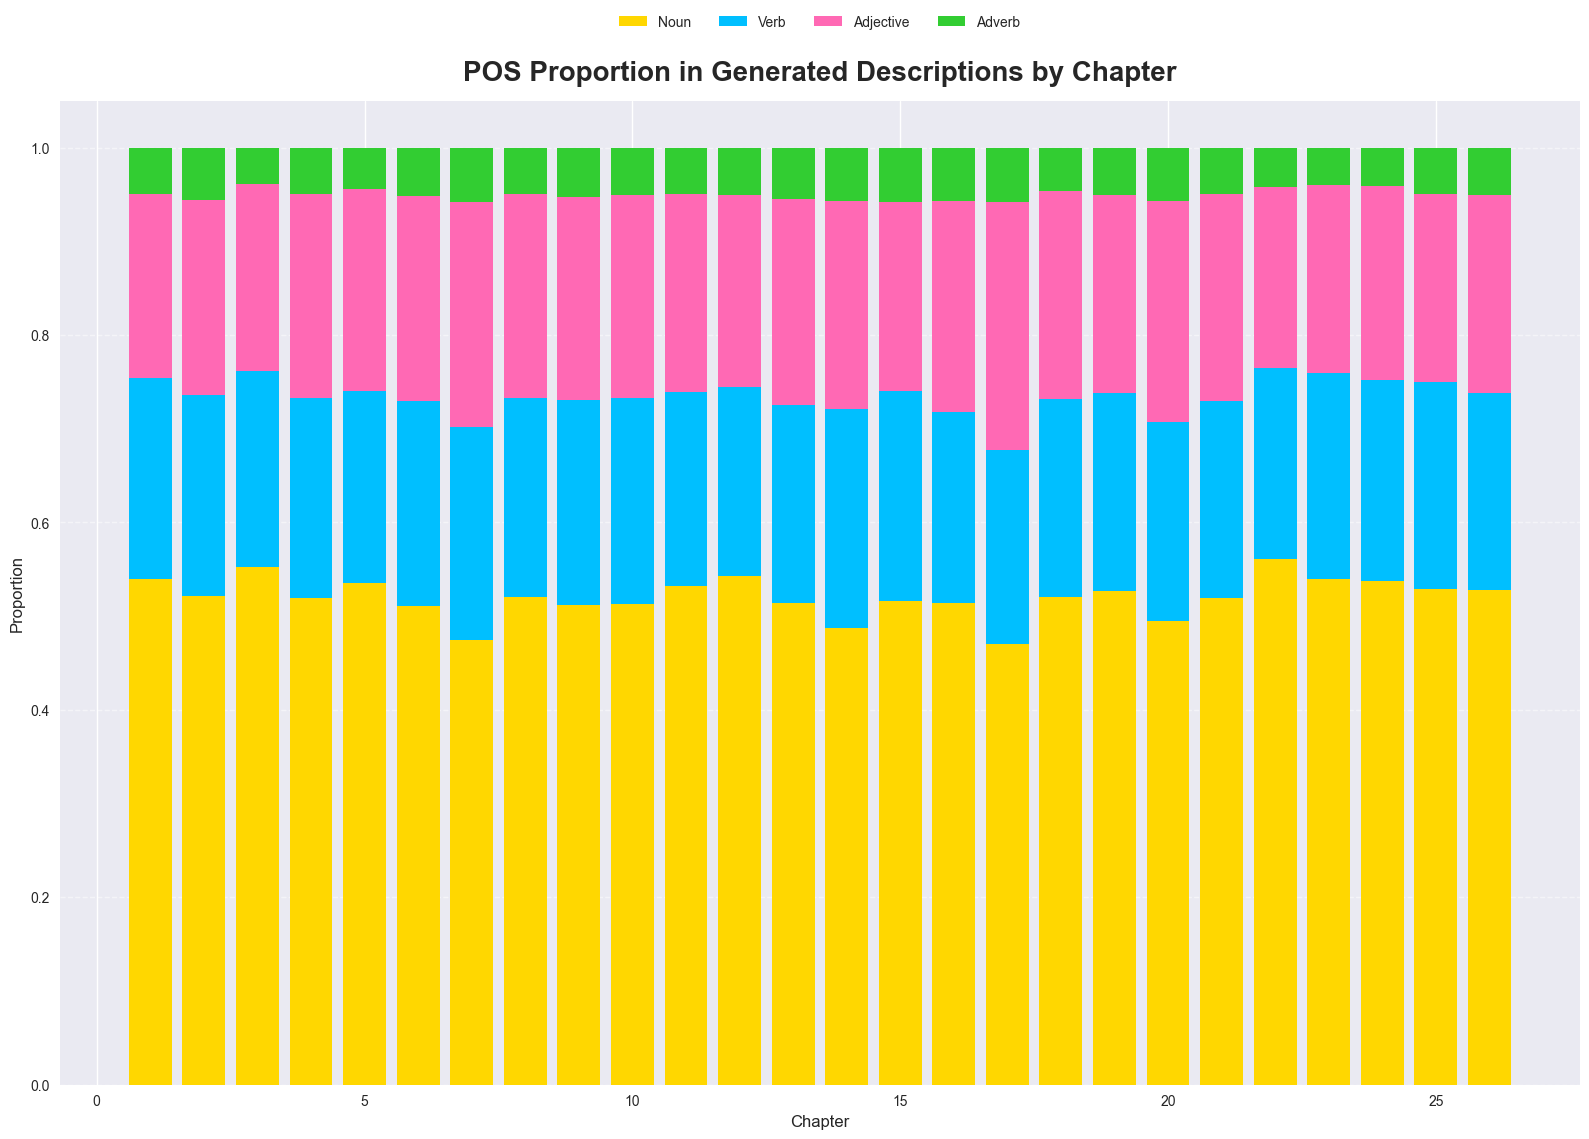

In [71]:
pos_analysis_pipeline(density_df)

## Overlap

In [56]:
# For n-gram overlap, BLEU/ROUGE, and topic modeling
overlap_df = create_preprocessed_columns(
    dg,
    to_lowercase=True,
    remove_punctuation=True,
    lemmatize=True,
    remove_stopwords=True
)

### N-gram

### BLUE/ROUGE Score

## Named Entity Recongition

In [ ]:
# For NER and sentiment analysis
ner_df = density_df

# Hierarchy Analysis

# Preparing for embeddings

In [38]:
dg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13960 entries, 0 to 13959
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           13960 non-null  int64 
 1   code                         13062 non-null  object
 2   title                        13960 non-null  object
 3   browser_url                  13960 non-null  object
 4   class_kind                   13960 non-null  object
 5   definition                   6894 non-null   object
 6   parent                       13960 non-null  int64 
 7   inclusions                   1113 non-null   object
 8   foundation_children          1468 non-null   object
 9   foundation_child_references  1468 non-null   object
 10  index_terms                  10855 non-null  object
 11  related_entities             2287 non-null   object
 12  full_text                    13960 non-null  object
 13  children                     32

In [50]:
dv = dg[['id', 'chapter', 'code', 'title', 'generated_description', 'inclusions', 'related_entities', 'children', 'exclusions']].copy()

In [70]:
def create_vectorization_text(df):
    # Create a copy of the dataframe
    df_vector = df.copy()
    
    # Create a dictionary for quick title lookup
    title_lookup = dict(zip(df['id'], df['title']))
    
    def process_row(row):
        # Start with the generated description
        vector_text = row['generated_description']
        
        # Get the condition name from title
        condition_name = row['title']
        
        # Process inclusions if available
        if pd.notna(row['inclusions']):
            # Split inclusions into list and clean
            inclusion_terms = [term.strip() for term in row['inclusions'].split(';')]
            # Filter out terms already in the description
            new_terms = [term for term in inclusion_terms 
                        if term.lower() not in vector_text.lower()]
            if new_terms:
                vector_text += f"\n{condition_name} includes the following diagnostic terms and synonyms: {', '.join(new_terms)}."
        
            # Process related entities if available
        if pd.notna(row['related_entities']):
            # Split related entities into list and clean
            related_ids = [id.strip() for id in row['related_entities'].split(';')]
            # Get titles for each ID
            related_titles = [title_lookup.get(int(id), '') for id in related_ids if id]
            related_titles = [title for title in related_titles if title]  # Remove empty strings
            # Filter out titles that are already mentioned in the text
            new_related_titles = [title for title in related_titles 
                                if title.lower() not in vector_text.lower()]
            if new_related_titles:
                vector_text += f"\n{condition_name} is clinically related to: {', '.join(new_related_titles)}."
        
        # Process children if available
        if pd.notna(row['children']):
            # Split children into list and clean
            child_ids = [id.strip() for id in row['children'].split(';')]
            # Get titles for each ID
            child_titles = [title_lookup.get(int(id), '') for id in child_ids if id and id not in ('other', 'unspecified')]
            child_titles = [title for title in child_titles if title]  # Remove empty strings
            if child_titles:
                vector_text += f"\n{condition_name} is a parent category that includes the following specific conditions: {', '.join(child_titles)}."
        
        # Process exclusions if available
        if pd.notna(row['exclusions']):
            # Split exclusions into list and clean
            exclusion_terms = [term.strip() for term in row['exclusions'].split(';')]
            # Filter out terms already in the description
            new_terms = [term for term in exclusion_terms 
                        if term.lower() not in vector_text.lower()]
            if new_terms:
                vector_text += f"\nTerms that are not categorized under {condition_name} are: {', '.join(new_terms)}."
        
        return vector_text
    
    # Apply the processing function to each row
    df_vector['vectorization_text'] = df_vector.apply(process_row, axis=1)
    
    return df_vector

In [73]:
df_with_vectorization = create_vectorization_text(dv)[['id', 'chapter', 'code', 'title', 'vectorization_text']]

In [76]:
df_with_vectorization.to_csv('icd11-25_data_vectorization.csv')